In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

import matplotlib.pyplot as plt


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [2]:
data, _ = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'),
                             return_X_y=True)
data_samples = data[:n_samples]

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

In [4]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [19]:
from sklearn_guided_lda import GuidedLatentDirichletAllocation

In [25]:
seeds = [
    ["game", "team", "play", "season"],
    ["religin", "christian", "god", "jesus"]
]
glda = GuidedLatentDirichletAllocation(tf_vectorizer=tf_vectorizer,
                                seed_words=seeds,
                                n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
glda.fit(tf)

GuidedLatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                                max_iter=5, random_state=0,
                                seed_words=[['game', 'team', 'play', 'season'],
                                            ['religin', 'christian', 'god',
                                             'jesus']],
                                tf_vectorizer=CountVectorizer(max_df=0.95,
                                                              max_features=1000,
                                                              min_df=2,
                                                              stop_words='english'))

In [11]:
tf_feature_names = tf_vectorizer.get_feature_names()

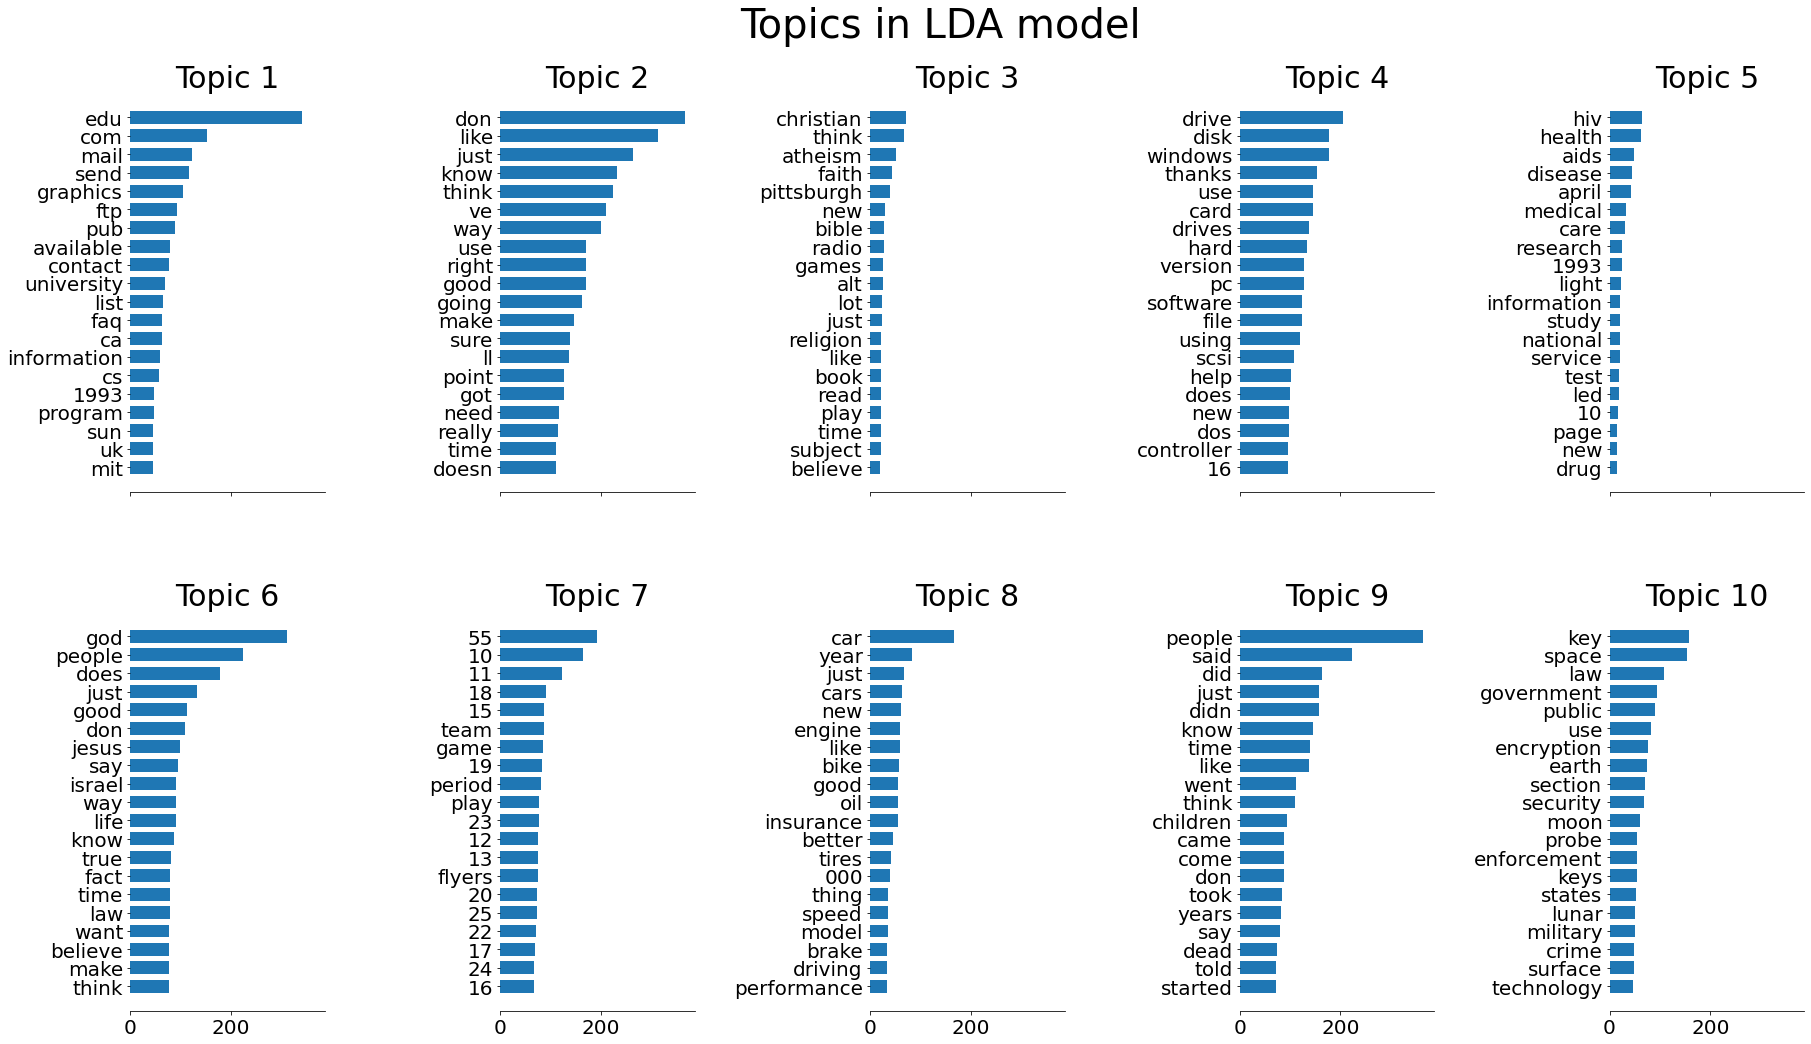

In [14]:
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

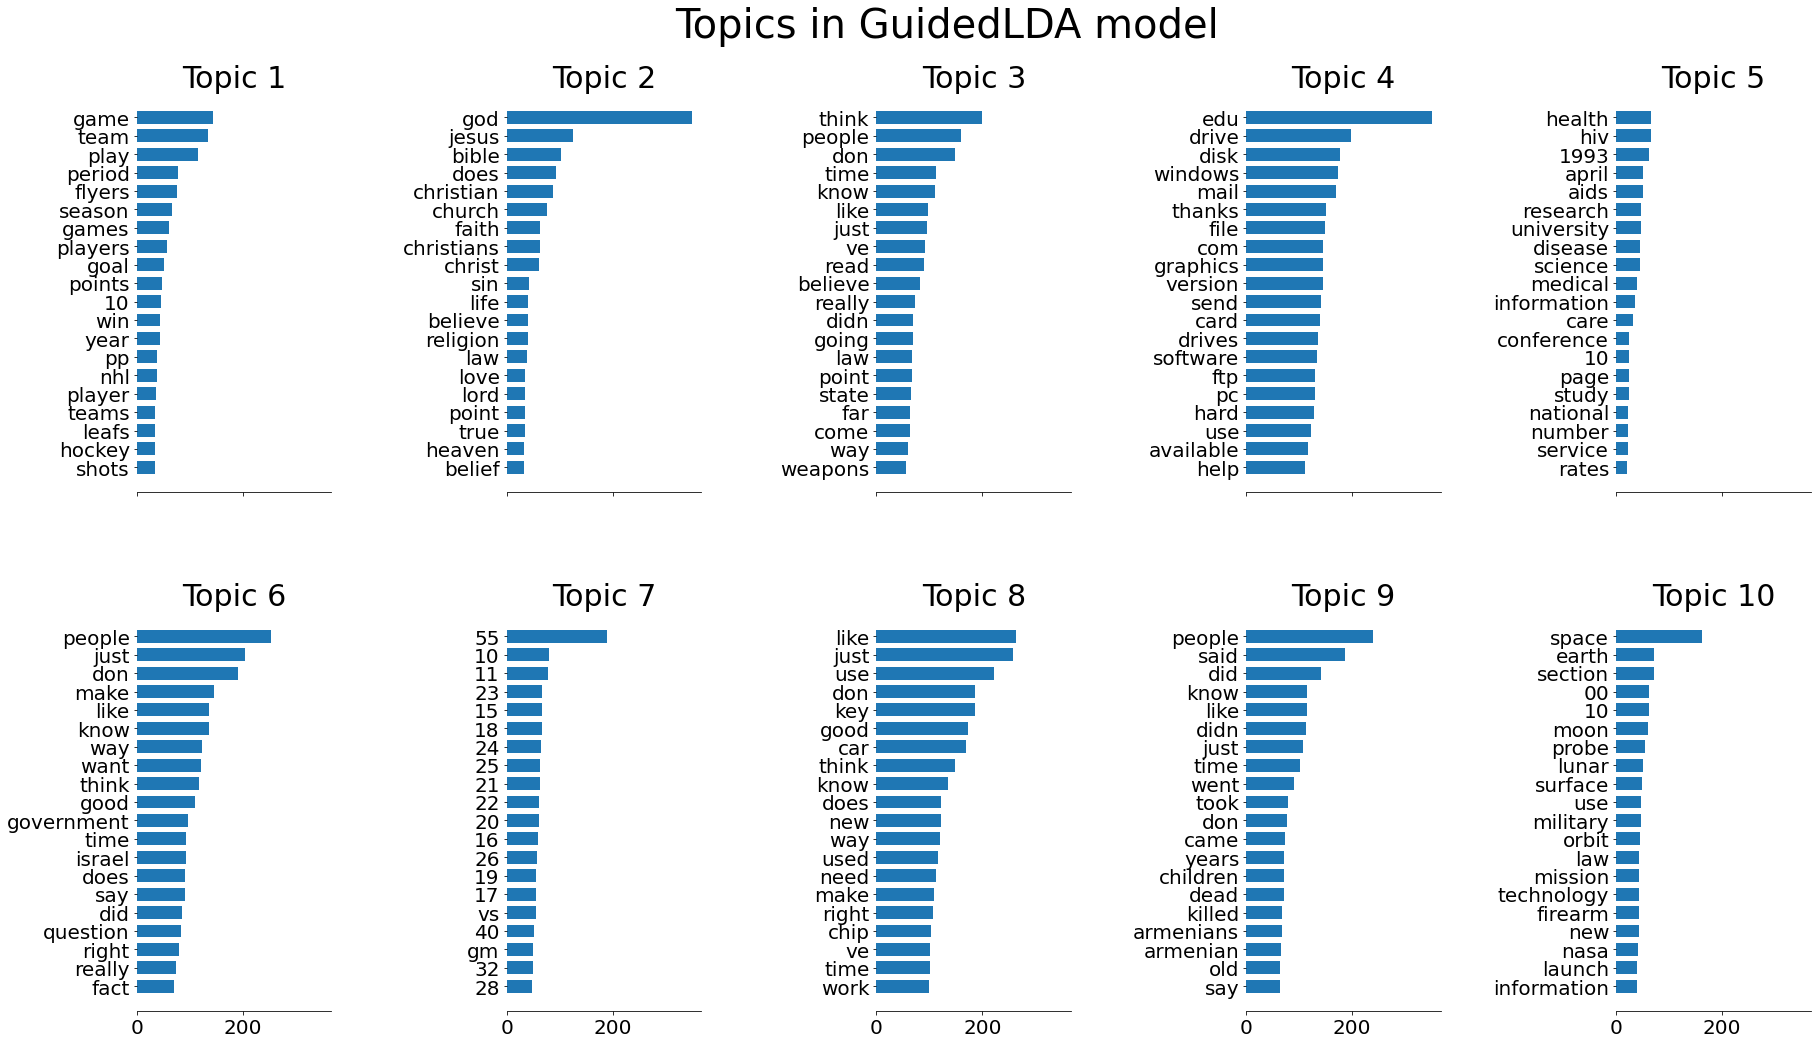

In [26]:
plot_top_words(glda, tf_feature_names, n_top_words, 'Topics in GuidedLDA model')